In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
% matplotlib inline

In [2]:
with open('c1p8.pkl', 'rb') as f:
    data = pickle.load(f, encoding='latin1')

In [3]:
def synthetic_neuron(drive):
    """
    Simulates a mock neuron with a time step of 1ms.
    
    Arguments:
    drive - input to the neuron (expect zero mean; SD=1)
    
    Returns:
    rho - response function (0=non-spike and 1=spike at each time step)
    """

    dt = .001
    T = dt*len(drive)
    time = np.arange(0, T, dt)
    lagSteps = int(.02 / dt)
    drive = np.concatenate((np.zeros(lagSteps), drive[lagSteps:]))
    system = scipy.signal.lti([1], [.03**2, 2*.03, 1])
    _, L, _ = scipy.signal.lsim(system, drive[:,np.newaxis], time)
    rate = np.divide(30, 1 + np.exp(50*(.05-L)))
    spikeProb = rate*dt
    return np.random.rand(len(spikeProb)) < spikeProb

# Spike Triggered Averages

In [4]:
def get_sta(spike_data, stim_data, window_ms, delta_ms):
    assert(window_ms % delta_ms == 0) # delta should divide evenly into window
    spike_data = np.asarray(spike_data)
    stim_data = np.asarray(stim_data)
    deltas_per_window = window_ms // delta_ms
    pre_spike_stims = [stim_data[i - deltas_per_window:i] for i, resp in enumerate(spike_data) 
                       if i >= deltas_per_window and resp == 1]
    sta = np.mean(pre_spike_stims, axis=0)
    times = np.linspace(-window_ms, 0, num=deltas_per_window, endpoint=False)
    return times, sta

In [5]:
rho = data['rho'].flatten()
s = data['stim'].flatten()
delta_t = 2 # ms
window = 200 # ms

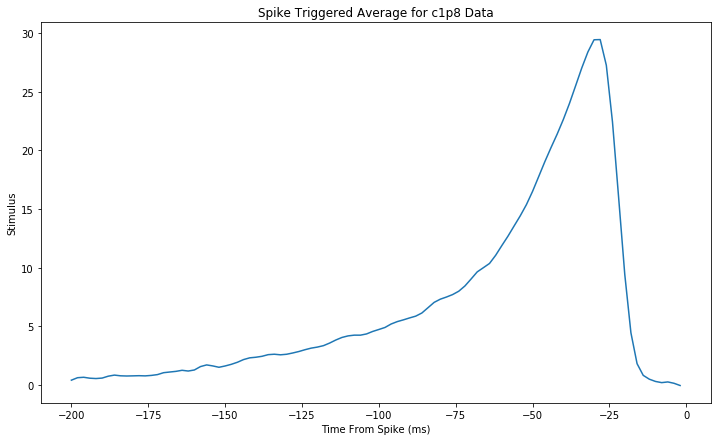

In [6]:
times, sta = get_sta(rho, s, window, delta_t)

plt.figure(figsize=(12,7))
plt.plot(times, sta)
plt.title('Spike Triggered Average for c1p8 Data')
plt.ylabel('Stimulus')
plt.xlabel('Time From Spike (ms)')
plt.show()

In [7]:
T = 100 * 1000 # 100s trial in ms
delta_t = 1 # ms
noise = np.random.normal(0,1,T)

In [8]:
spikes = synthetic_neuron(noise).astype(int)

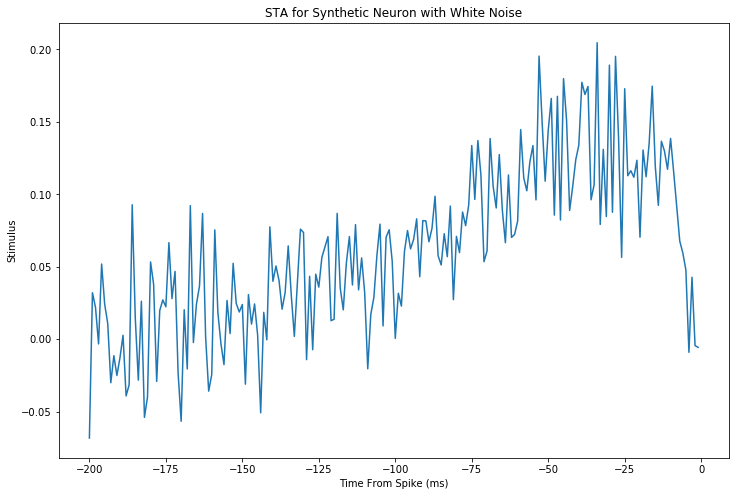

In [9]:
times, sta = get_sta(spikes, noise, 200, delta_t)

plt.figure(figsize=(12,8))
plt.plot(times, sta)
plt.title('STA for Synthetic Neuron with White Noise')
plt.ylabel('Stimulus')
plt.xlabel('Time From Spike (ms)')
plt.show()

In [10]:
def gaussian(x, mu, sigma):
    return 1. / (np.sqrt(2. * np.pi) * sigma) * np.exp(-np.power((x - mu) / sigma, 2.) / 2)

In [11]:
kernel = [gaussian(x, 0, 20) for x in np.arange(-50, 51, 1)]
coloured_noise = np.convolve(kernel, noise, mode='same')

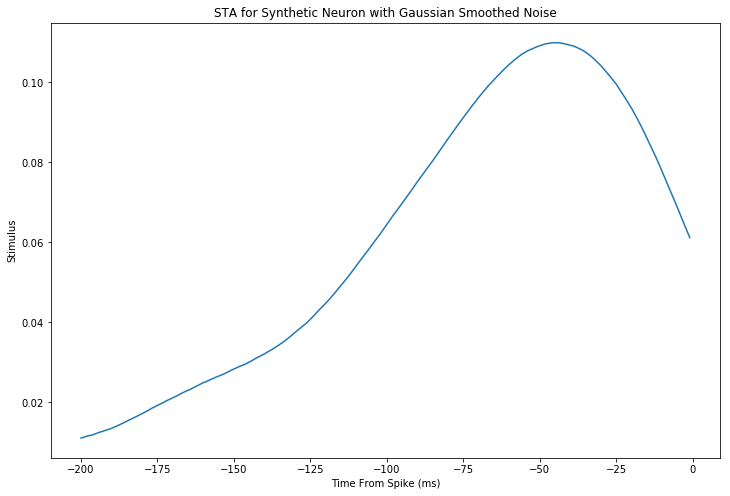

In [12]:
spikes = synthetic_neuron(coloured_noise).astype(int)

times, sta = get_sta(spikes, coloured_noise, 200, delta_t)

plt.figure(figsize=(12,8))
plt.plot(times, sta)
plt.title('STA for Synthetic Neuron with Gaussian Smoothed Noise')
plt.ylabel('Stimulus')
plt.xlabel('Time From Spike (ms)')
plt.show()

### Difference in STA plots between white and coloured noise

The STA for the the coloured noise stimulus does not have any lag before the spike. It doesn't hit 0 before the spike begins. This is because the noise is autocorrelated. We do not see the same lack of lag in the STA from the white noise as that stimulus is not autocorrelated. It hits 0 before spike time. It is also much less noisy due to the signal getting smoothed.